## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dirty_completeness

## Useful Functions

In [2]:
def hists_plot(df):
    fig, axes = plt.subplots(1, len(df.columns), figsize=(20,5))
    ax = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.countplot(df, x=col, ax=axes[i], order=sorted(df[col].value_counts().index))

In [3]:
def accuracy(df, df_imputed):
    accuracy = {}
    for col in df.columns:
        equal = np.where(df[col] == df_imputed[col], True, False)
        accuracy[col] = equal[equal == True].sum() / len(equal)
    return accuracy

In [4]:
def jaccard_dist(a,b):
    intersction =len(set(a).intersection(b))
    union = len(a) + len(b) -intersction
    return 1 - float(intersction) / union

## Read data

In [5]:
users = pd.read_csv('users.csv')

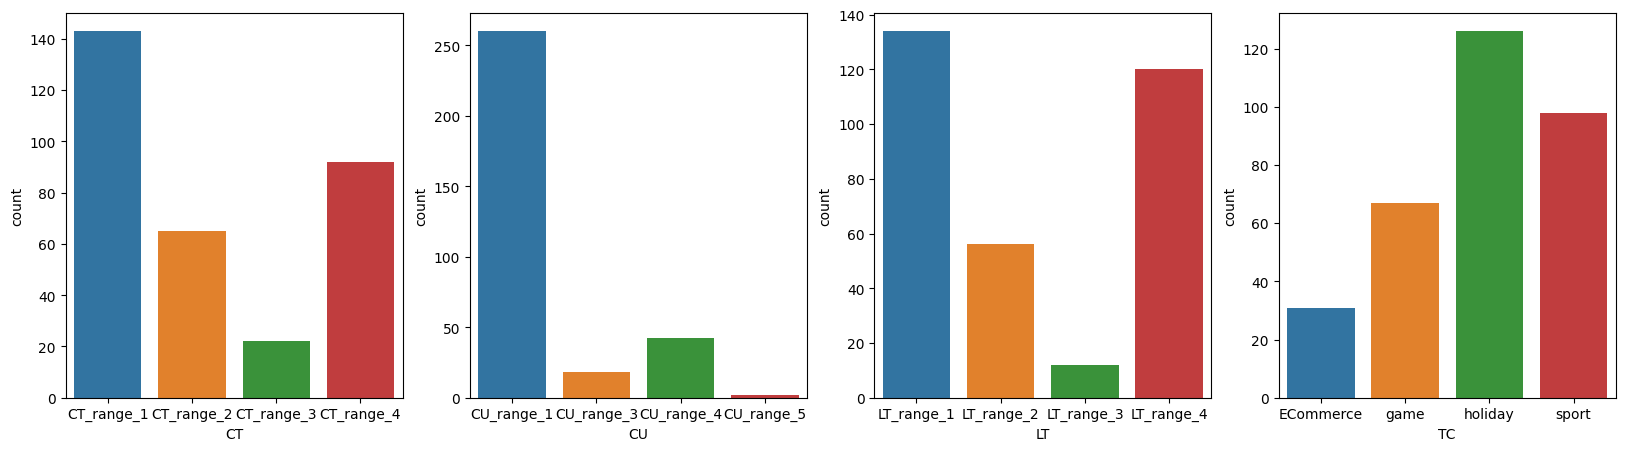

In [6]:
hists_plot(users)

## Shuffle data

In [7]:
users = users.sample(frac=1, axis=0).reset_index(drop=True)

## Inject null values

In [8]:
users_dirty = np.array(dirty_completeness.injection(df_pandas=users, seed=1234, name = 'users', name_class="none"))

saved users-completeness50%
saved users-completeness60%
saved users-completeness70%
saved users-completeness80%
saved users-completeness90%


In [9]:
users_dirty = users_dirty[0,:,:] #50% completeness

In [10]:
users_dirty = pd.DataFrame(users_dirty,columns=users.columns)

In [11]:
users_dirty

,CT,CU,LT,TC
0,NaN,CU_range_1,NaN,NaN
1,CT_range_4,CU_range_1,LT_range_1,game
2,NaN,CU_range_4,NaN,sport
3,CT_range_4,NaN,NaN,game
4,CT_range_2,CU_range_1,LT_range_4,NaN
...,...,...,...,...
317,CT_range_1,NaN,LT_range_4,sport
318,CT_range_2,NaN,NaN,NaN
319,CT_range_4,NaN,LT_range_1,game
320,CT_range_3,CU_range_1,LT_range_4,NaN


## Visualizing null values

<AxesSubplot:>

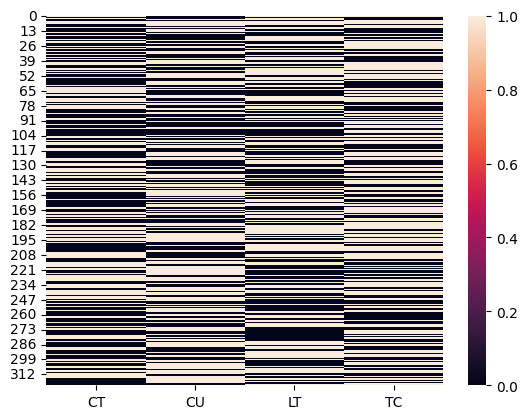

In [12]:
sns.heatmap(users_dirty.isna())

## Simple Imputation

In [13]:
users_simple_imp = users_dirty.fillna(method='ffill')
users_simple_imp.isna().count()
users_simple_imp = users_simple_imp.fillna(method='bfill')

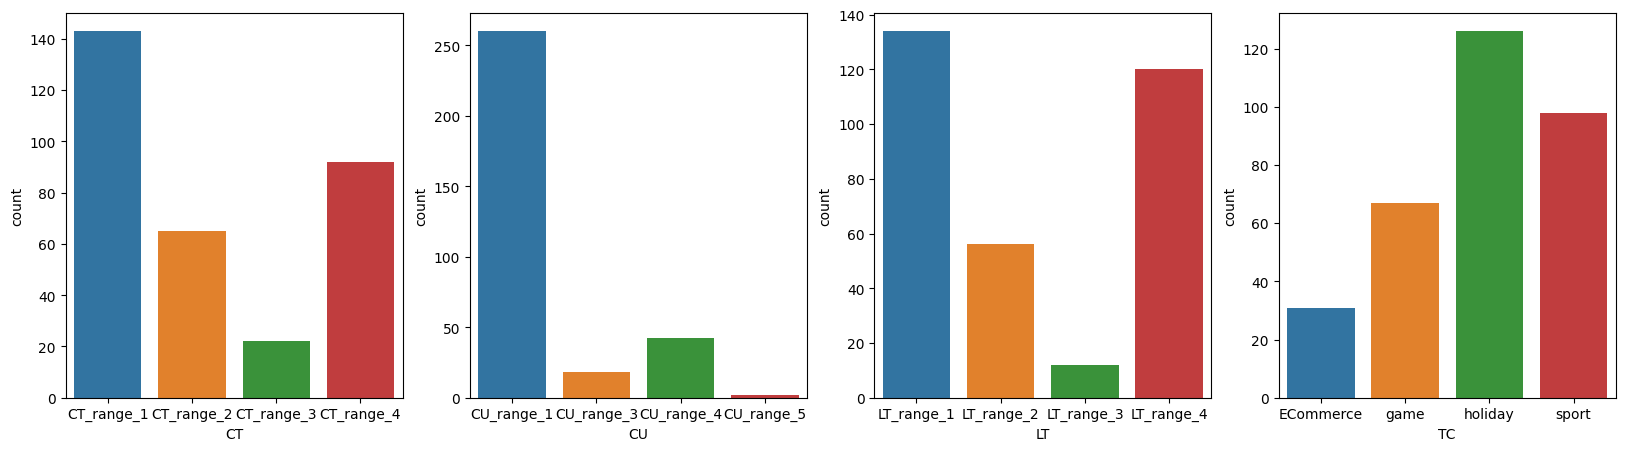

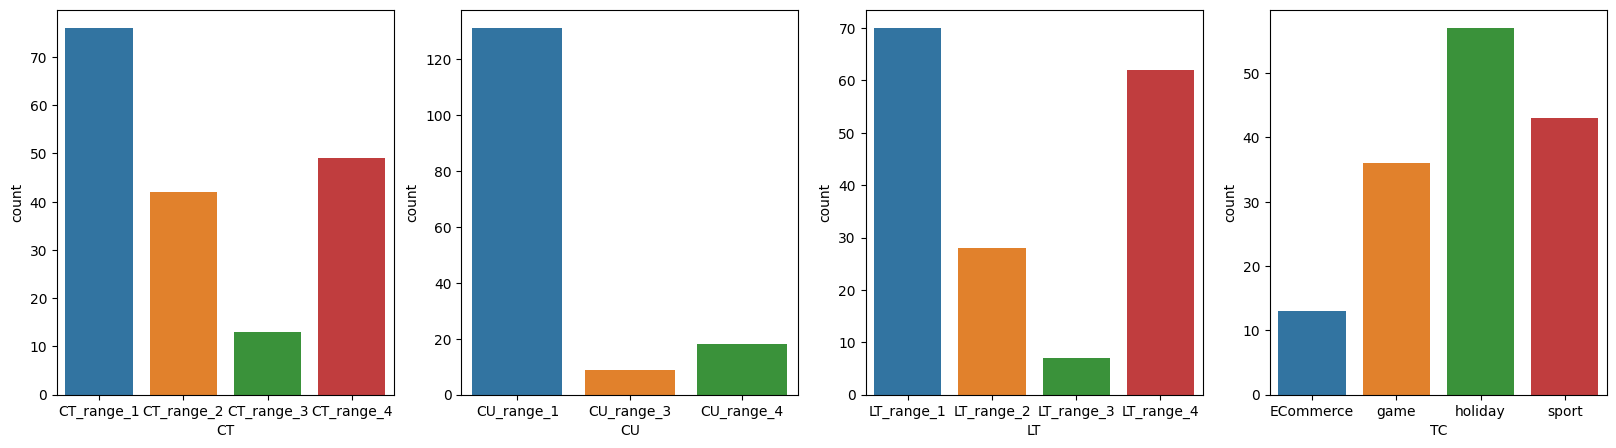

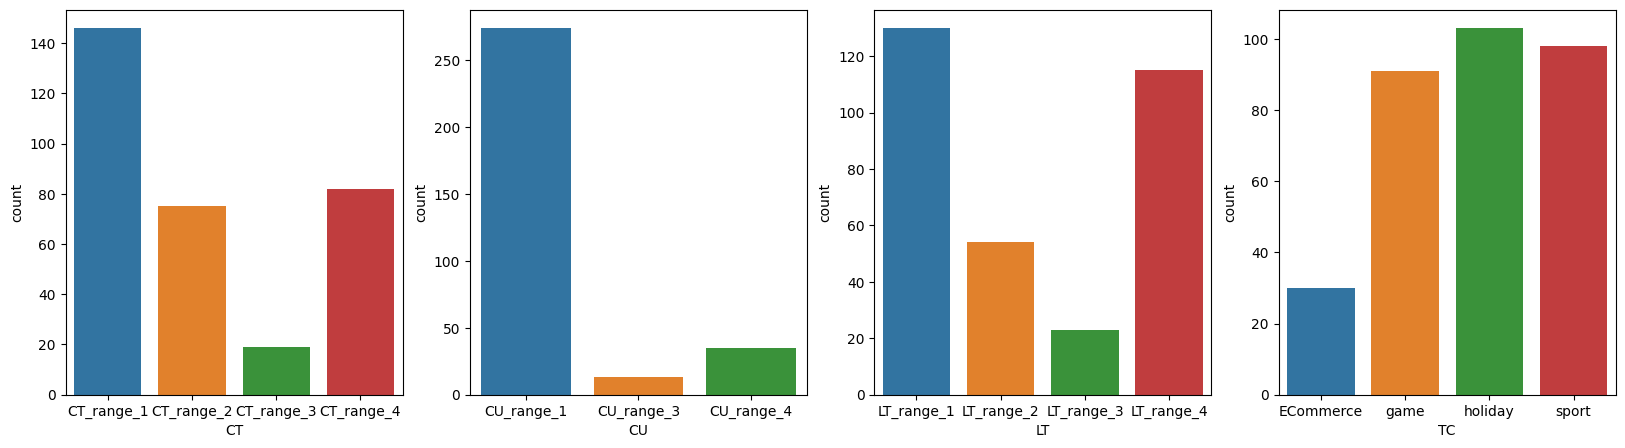

In [14]:
hists_plot(users)
hists_plot(users_dirty)
hists_plot(users_simple_imp)

In [15]:
accuracy(users, users_simple_imp)

{'CT': 0.717391304347826,
 'CU': 0.8571428571428571,
 'LT': 0.6739130434782609,
 'TC': 0.6086956521739131}

## Advanced Imputation

In [16]:
users_dirty_one_hot = pd.get_dummies(users_dirty)
for col in users_dirty.columns:
    users_dirty_one_hot.loc[users_dirty[col].isnull(), users_dirty_one_hot.columns.str.startswith(col)] = np.nan

In [17]:
from sklearn.impute import KNNImputer

In [18]:
knn_imputer = KNNImputer(n_neighbors=4)
users_knn_imp_one_hot = pd.DataFrame(knn_imputer.fit_transform(users_dirty_one_hot))
users_knn_imp_one_hot.columns = users_dirty_one_hot.columns

In [19]:
users_knn_imp = pd.DataFrame()
for col in users_dirty.columns:
   users_knn_imp[col] = users_knn_imp_one_hot.loc[:, users_knn_imp_one_hot.columns.str.startswith(col)].idxmax(1)
users_knn_imp = users_knn_imp.apply(lambda e: e.str[3:] )

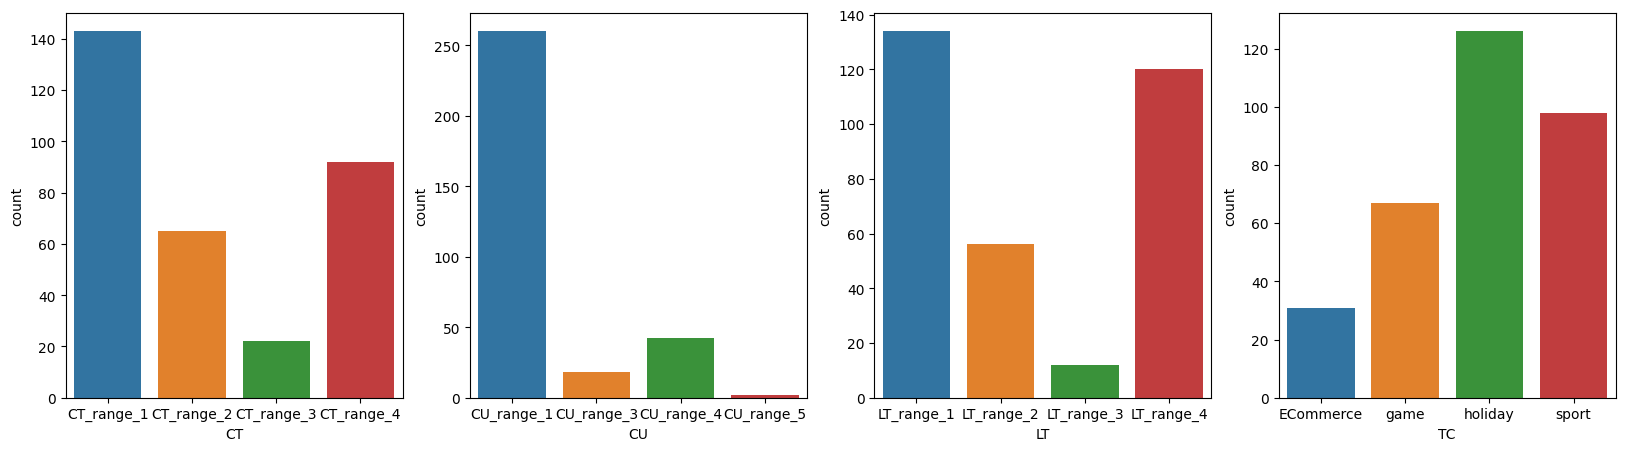

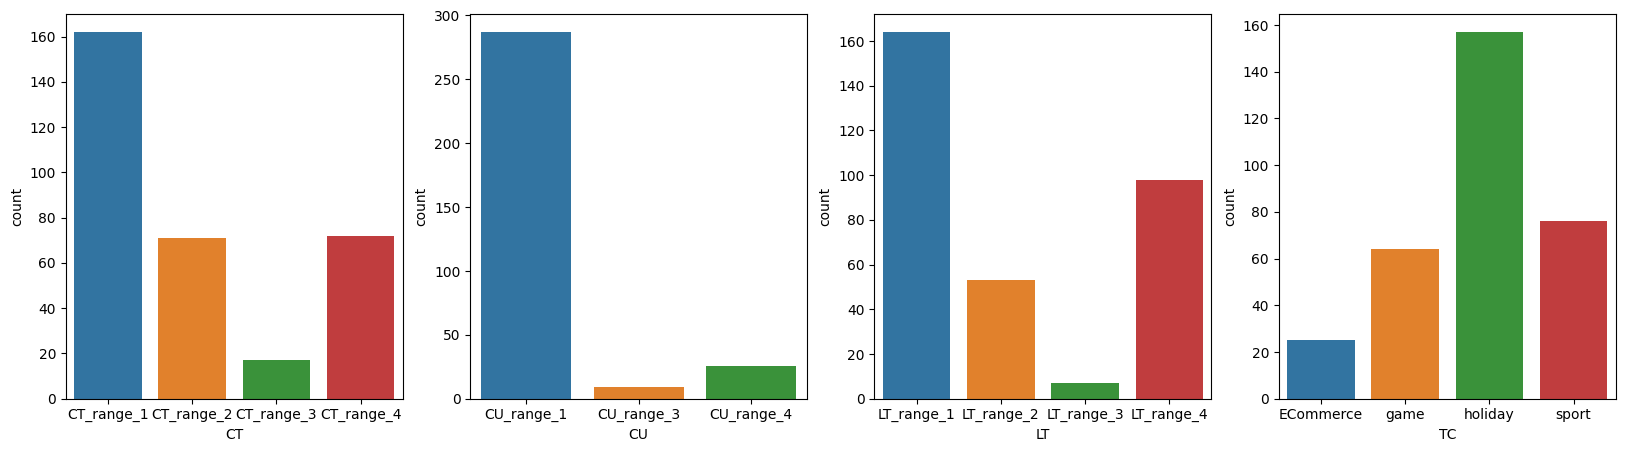

In [20]:
hists_plot(users)
hists_plot(users_knn_imp)

In [21]:
accuracy(users,users_knn_imp)

{'CT': 0.7795031055900621,
 'CU': 0.9006211180124224,
 'LT': 0.782608695652174,
 'TC': 0.7795031055900621}

## Clustering

Because of the categorical nature of the dataset, KModes is performed

In [22]:
%pip install kmodes

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [23]:
from kmodes.kmodes import KModes

In [24]:
# Elbow curve to find optimal K
def elbow(df, k_max=15):
    cost = []
    K = range(1,k_max)
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0)
        kmode.fit_predict(df)
        cost.append(kmode.cost_)
        
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Method For Optimal k')


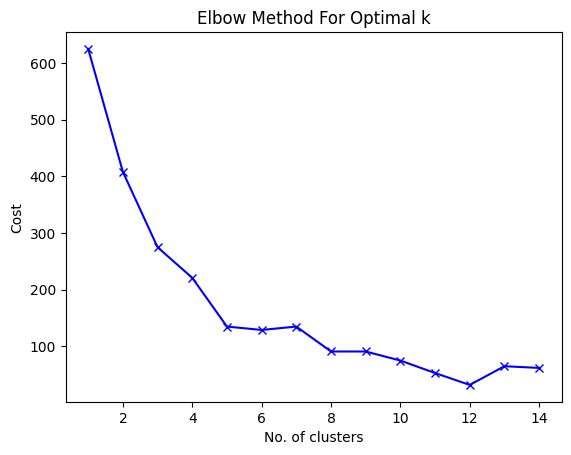

In [25]:
elbow(users)

According to the elbow plot we get the optimal number of cluster k=5

In [26]:
kmodes = KModes(n_jobs = -1, n_clusters = 5, init = 'random', random_state = 0)
kmodes.fit_predict(users_knn_imp)

array([4, 3, 1, 3, 4, 2, 2, 3, 2, 0, 2, 0, 3, 3, 3, 1, 3, 3, 0, 0, 4, 1,
       2, 2, 1, 3, 2, 1, 1, 3, 3, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       1, 2, 4, 1, 4, 2, 1, 3, 2, 2, 3, 2, 3, 0, 0, 1, 1, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 3, 2, 4, 4, 1, 1, 2, 3, 2, 3, 2, 1, 1, 2, 2, 2, 3, 0,
       2, 2, 4, 1, 2, 2, 1, 3, 2, 2, 1, 3, 2, 1, 1, 1, 0, 4, 0, 2, 0, 0,
       4, 2, 2, 0, 2, 2, 1, 2, 0, 0, 2, 0, 3, 3, 2, 2, 1, 2, 1, 2, 2, 0,
       0, 1, 1, 0, 1, 3, 2, 3, 2, 2, 1, 2, 2, 1, 3, 2, 2, 1, 3, 0, 2, 2,
       1, 3, 3, 3, 1, 1, 2, 0, 1, 0, 2, 2, 3, 1, 1, 3, 3, 4, 1, 1, 2, 1,
       1, 4, 2, 3, 2, 2, 2, 0, 2, 4, 2, 0, 4, 2, 3, 2, 2, 2, 1, 2, 2, 0,
       0, 3, 0, 0, 2, 2, 0, 1, 2, 2, 4, 4, 1, 2, 2, 2, 3, 1, 1, 3, 2, 2,
       1, 2, 1, 1, 1, 2, 2, 3, 3, 2, 1, 3, 3, 1, 2, 4, 2, 2, 1, 3, 4, 2,
       0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 3, 1, 2, 3, 1, 0, 0, 1, 2, 0, 3, 0,
       1, 0, 3, 2, 0, 2, 4, 0, 1, 1, 1, 4, 3, 2, 2, 0, 2, 4, 0, 3, 2, 2,
       2, 0, 2, 1, 0, 3, 2, 1, 0, 4, 0, 1, 1, 1, 0,

In [27]:
print(kmodes.cluster_centroids_)

[['CT_range_2' 'CU_range_1' 'LT_range_2' 'holiday']
 ['CT_range_1' 'CU_range_1' 'LT_range_4' 'sport']
 ['CT_range_1' 'CU_range_1' 'LT_range_1' 'holiday']
 ['CT_range_4' 'CU_range_1' 'LT_range_1' 'game']
 ['CT_range_2' 'CU_range_1' 'LT_range_4' 'holiday']]


In [28]:
users_cluster_kmodes = pd.DataFrame.copy(users)
users_cluster_kmodes['Cluster'] = kmodes.labels_

In [29]:
users_cluster_kmodes

,CT,CU,LT,TC,Cluster
0,CT_range_4,CU_range_1,LT_range_4,sport,4
1,CT_range_4,CU_range_1,LT_range_1,game,3
2,CT_range_1,CU_range_4,LT_range_4,sport,1
3,CT_range_4,CU_range_1,LT_range_3,game,3
4,CT_range_2,CU_range_1,LT_range_4,sport,4
...,...,...,...,...,...
317,CT_range_1,CU_range_3,LT_range_4,sport,1
318,CT_range_2,CU_range_1,LT_range_2,holiday,0
319,CT_range_4,CU_range_1,LT_range_1,game,3
320,CT_range_3,CU_range_1,LT_range_4,sport,1


## Agglomerative Hierarchical Clustering

In [30]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

### Compute the distance matrix using Jaccard Distance

In [31]:
dist_matrix = np.asarray( [[jaccard_dist(a,b) for _,b in users.iterrows()] for _,a in users.iterrows()])

In [32]:
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,320,321
0,0.000000,0.666667,0.666667,0.666667,0.400000,0.666667,0.857143,0.666667,0.857143,0.857143,...,0.857143,0.857143,0.666667,0.857143,0.666667,0.666667,0.857143,0.666667,0.400000,0.857143
1,0.666667,0.000000,1.000000,0.400000,0.857143,1.000000,0.666667,0.000000,0.666667,0.857143,...,0.666667,0.666667,0.000000,0.857143,1.000000,1.000000,0.857143,0.000000,0.857143,0.857143
2,0.666667,1.000000,0.000000,1.000000,0.666667,0.400000,0.857143,1.000000,0.857143,1.000000,...,0.857143,0.857143,1.000000,1.000000,0.000000,0.400000,1.000000,1.000000,0.666667,1.000000
3,0.666667,0.400000,1.000000,0.000000,0.857143,1.000000,0.857143,0.400000,0.857143,0.857143,...,0.857143,0.857143,0.400000,0.857143,1.000000,1.000000,0.857143,0.400000,0.857143,0.857143
4,0.400000,0.857143,0.666667,0.857143,0.000000,0.666667,0.857143,0.857143,0.857143,0.666667,...,0.857143,0.857143,0.857143,0.666667,0.666667,0.666667,0.666667,0.857143,0.400000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0.666667,1.000000,0.400000,1.000000,0.666667,0.000000,0.857143,1.000000,0.857143,1.000000,...,0.857143,0.857143,1.000000,1.000000,0.400000,0.000000,1.000000,1.000000,0.666667,1.000000
318,0.857143,0.857143,1.000000,0.857143,0.666667,1.000000,0.666667,0.857143,0.666667,0.000000,...,0.666667,0.666667,0.857143,0.000000,1.000000,1.000000,0.000000,0.857143,0.857143,0.000000
319,0.666667,0.000000,1.000000,0.400000,0.857143,1.000000,0.666667,0.000000,0.666667,0.857143,...,0.666667,0.666667,0.000000,0.857143,1.000000,1.000000,0.857143,0.000000,0.857143,0.857143
320,0.400000,0.857143,0.666667,0.857143,0.400000,0.666667,0.857143,0.857143,0.857143,0.857143,...,0.857143,0.857143,0.857143,0.857143,0.666667,0.666667,0.857143,0.857143,0.000000,0.857143


### Perform the Agglomerative Clustering

In [52]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

In [53]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed',linkage='complete').fit(dist_matrix)

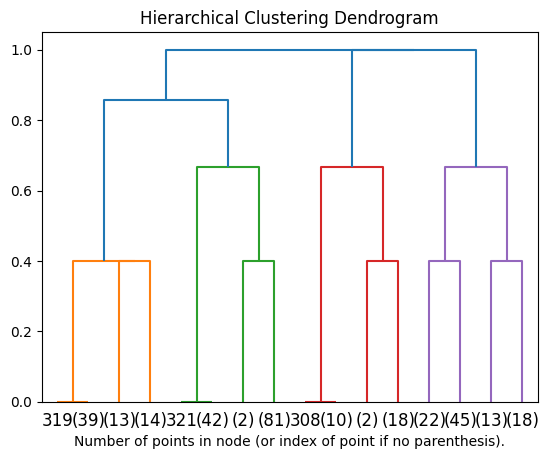

In [62]:
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=3)

In [63]:
agglomerative = AgglomerativeClustering(n_clusters=5, affinity='precomputed',linkage='single').fit(dist_matrix)


In [64]:
users_cluster_agglomerative = pd.DataFrame.copy(users)
agglomerative
users_cluster_agglomerative['Cluster'] = agglomerative.labels_
users_cluster_agglomerative

,CT,CU,LT,TC,Cluster
0,CT_range_4,CU_range_1,LT_range_4,sport,2
1,CT_range_4,CU_range_1,LT_range_1,game,2
2,CT_range_1,CU_range_4,LT_range_4,sport,0
3,CT_range_4,CU_range_1,LT_range_3,game,2
4,CT_range_2,CU_range_1,LT_range_4,sport,2
...,...,...,...,...,...
317,CT_range_1,CU_range_3,LT_range_4,sport,0
318,CT_range_2,CU_range_1,LT_range_2,holiday,1
319,CT_range_4,CU_range_1,LT_range_1,game,2
320,CT_range_3,CU_range_1,LT_range_4,sport,2
